# Predicting Housing prices on the Ames, Iowa data from Kaggle

## Objective:
- Clean data in both training and testing data
- Use KNN to impute missing values for sparse features
- Make all data usable in algorithms for prediction
- Use K Means ++ on both quantitative and qualitative data to group similar houses together
- Run Random Forest to see the effectivness of using clustering by looking at the most important features
- Using Gradient Boosted Decision Trees for predicting housing prices on testing data

Loading the dataset and libraries

In [1]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa as tsa
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from patsy import ModelDesc, Term, EvalFactor
from patsy import dmatrix
from __future__ import print_function
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer


data = pd.read_csv('train.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Before doing any analysis, we want to see how sparse the data is

In [2]:
missing_values = (train.isnull().sum())
print(missing_values[missing_values > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


For book keeping, we need to keep track of how many training observations there are.

In [3]:
print(f"The training dataset contains {len(train)} values")

The training dataset contains 1460 values


The columns that have the highest amounts of missing features don't have those features. We'll simply fill the na values for those with 0s and use KNN for imputation on the other values

For ease of coding, we're going to concatenate the train and testing datasets together to make the changes then split them apart to their original datasets.

In [4]:
train.drop(['SalePrice'], axis = 1, inplace=True) 
merge = [train, test]
pipe = pd.concat(merge)

In [5]:
missing_values2 = (pipe.isnull().sum())
print(missing_values2[missing_values2 > 0])

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


Fortunately, it seems that when lot frontage is missing values it is because there is no lot frontage because there is no 0 entry.

In [6]:
pipe["LotFrontage"].fillna(0, inplace = True)

First, We'll do the simple task of filling the non-categorical and non-qualitative values with a large amount of data missing with 0s or nones and splitting them into dummy variables.

In [7]:
impute1 = ['Alley','Fence', 'MiscFeature']
for i in impute1:
    pipe[f'{i}'].fillna("None", inplace = True)
    
#Becaues there are so few pools, we're not going to treat pool quality as most of the other quality variables.
pipe['Has_Pool'] = pipe.PoolQC.isnull().map({True: 0, False: 1})
#Same applies to fireplace
pipe['Has_Fireplace'] = pipe.FireplaceQu.isnull().map({True: 0, False: 1})
#Now we drop the original variables
pipe.drop(['PoolQC', 'FireplaceQu'], axis = 1, inplace=True) 



Garage is a little complex because the data isn't completely balanced with missing features and perhaps the presence of no garage. Because of this, the following block of code tries to address the garage missing values as best as possible.

In [8]:
print(f"There are {len(pipe.loc[pipe['GarageArea'] == 0])} houses with a garage without area. Implying no garage.")

There are 157 houses with a garage without area. Implying no garage.


There are 159 missing values for garage year built and garage finish. This is an additional 2 missing values that will be imputed with KNN

In [9]:
# Creating a variable for having a garage for a house having a garage for getting around this issue
pipe['Has_Garage'] = pipe.GarageType.isnull().map({True: 0, False: 1})

In [10]:
def grg_func(df):
    if df.Has_Garage == 0:
        return 0
    else:
        return df.GarageYrBlt

def grg_func2(df):
    if df.Has_Garage == 0:
        return "None"
    else:
        return df.GarageFinish
    
def grg_func3(df):
    if df.Has_Garage == 0:
        return "None"
    else:
        return df.GarageQual

def grg_func4(df):
    if df.Has_Garage == 0:
        return "None"
    else:
        return df.GarageCond

In [11]:
pipe['GarageYrBlt'] = pipe.apply(grg_func, axis = 1)
pipe['GarageFinish'] = pipe.apply(grg_func2, axis = 1)
pipe['GarageQual'] = pipe.apply(grg_func3, axis = 1)
pipe['GarageCond'] = pipe.apply(grg_func4, axis = 1)

pipe['GarageType'].fillna("None", inplace = True)

Basement is a bit more complicated to tell exactly if the house has a basement or not. We're going to assume that if Total Basement Square Feet is 0, then that means there is no basement. This will follow a similar coding scheme to the garage.

In [12]:
def bsmt_func(df):
    if df.TotalBsmtSF == 0:
        return "None"
    else:
        return df.BsmtFinType1

def bsmt_func2(df):
    if df.TotalBsmtSF == 0:
        return "None"
    else:
        return df.BsmtQual

def bsmt_func3(df):
    if df.TotalBsmtSF == 0:
        return "None"
    else:
        return df.BsmtCond

def bsmt_func4(df):
    if df.TotalBsmtSF == 0:
        return "None"
    else:
        return df.BsmtExposure

def bsmt_func5(df):
    if df.TotalBsmtSF == 0:
        return "None"
    else:
        return df.BsmtFinType2

    

    
pipe['BsmtFinType1'] = pipe.apply(bsmt_func, axis = 1)
pipe['BsmtQual'] = pipe.apply(bsmt_func2, axis = 1)
pipe['BsmtCond'] = pipe.apply(bsmt_func3, axis = 1)
pipe['BsmtExposure'] = pipe.apply(bsmt_func4, axis = 1)
pipe['BsmtFinType2'] = pipe.apply(bsmt_func5, axis = 1)

We need to split the imputation into 2 seperate processes. This is because there is string data that needs to be imputed with the most frequent as opposed to average.

In [13]:
# From data analysis...
pipe.drop(['BedroomAbvGr'], axis = 1, inplace=True) 
replace_values1 = {30: 1, 45: 1, 90 : 1, 160: 1, 180: 1, 190: 1, 40: 2, 50:2, 85: 2,  20 : 3, 70 : 3, 75: 3, 80 : 3, 150: 3, 120 : 4, 60 : 5 }
pipe =pipe.replace({'MSSubClass' : replace_values1})

In [14]:
pipenum = pd.DataFrame(pipe._get_numeric_data(), columns =pipe._get_numeric_data().columns)
pipenon = pipe.copy()
dropme = []
for col in pipe:
    if col in pipenum:
        dropme.append(col)
for i in dropme:
    pipenon.drop([f"{i}"], axis = 1, inplace = True)

In [15]:
my_imputer = SimpleImputer()
pipenum2 = my_imputer.fit_transform(pipenum)
pipenum3 = pd.DataFrame(data=pipenum2[0:,0:], index=[i for i in range(pipenum.shape[0])], columns= pipenum.columns)

my_imputer2 = SimpleImputer(strategy = 'most_frequent')
pipenon2 = my_imputer2.fit_transform(pipenon)
pipenon3 = pd.DataFrame(data=pipenon2[0:,0:], index=[i for i in range(pipenum.shape[0])], columns= pipenon.columns)

Before merging the dataframes with now 0 null values together then splitting them back apart into training and testing data, we'll take advantage of the string features being on their own to further separate the ordinal and categorical values.

In [16]:
pipenon3

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Typ,Attchd,RFn,TA,TA,Y,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Typ,Attchd,RFn,TA,TA,Y,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Typ,Attchd,RFn,TA,TA,Y,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Typ,Detchd,Unf,TA,TA,Y,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Typ,Attchd,RFn,TA,TA,Y,None,None,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,Typ,None,None,None,None,Y,None,None,WD,Normal
2915,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,Typ,CarPort,Unf,TA,TA,Y,None,None,WD,Abnorml
2916,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Typ,Detchd,Unf,TA,TA,Y,None,None,WD,Abnorml
2917,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Typ,None,None,None,None,Y,MnPrv,Shed,WD,Normal


One Hot encoding for ordinal data:

In [17]:
hotencoding1 = ['GarageCond','GarageQual','KitchenQual','HeatingQC','BsmtCond','BsmtQual','ExterCond','ExterQual']
replace_values = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 3, "Ex": 4 }
for i in hotencoding1:
    pipenon3 = pipenon3.replace({f'{i}' : replace_values})
pipequal = pd.get_dummies(pipenon3, drop_first=True)

Merging the two back together with 0 null values:

Creating a new feaeture for total square feet

In [18]:
features_to_sum = ['TotalBsmtSF','1stFlrSF','2ndFlrSF','GarageArea']
pipenum['newTotalSF'] = pipe[features_to_sum].sum(axis=1)
pipenum.drop(['Id'], axis = 1, inplace=True) 

Using Kmeans ++ to create clusters on both quantitative and qualitative data to help with predictions.

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pipe_scaled = scaler.fit_transform(pipenum3)

Text(0, 0.5, 'Inertia')

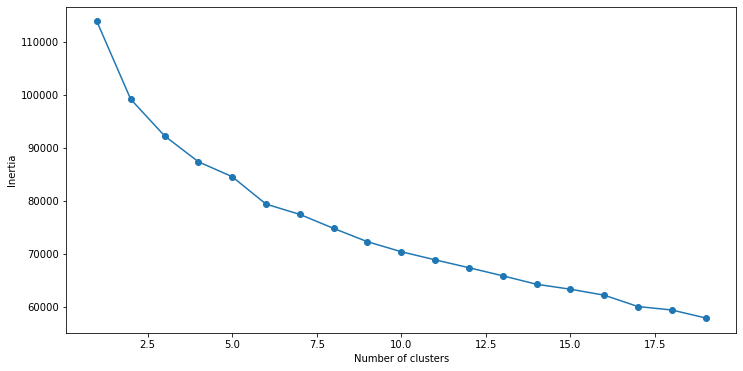

In [20]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(pipe_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

It appears that 4 clusters will be optimal from the "elbow plot"

In [21]:
kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
kmeans.fit(pipe_scaled)
pred = kmeans.predict(pipe_scaled)
frame1 = pd.DataFrame(pipe_scaled, columns= pipenum3.columns)
frame1['cluster'] = pred
frame1['cluster'].value_counts()

1    1378
3     736
2     648
0     157
Name: cluster, dtype: int64

Text(0, 0.5, 'Inertia')

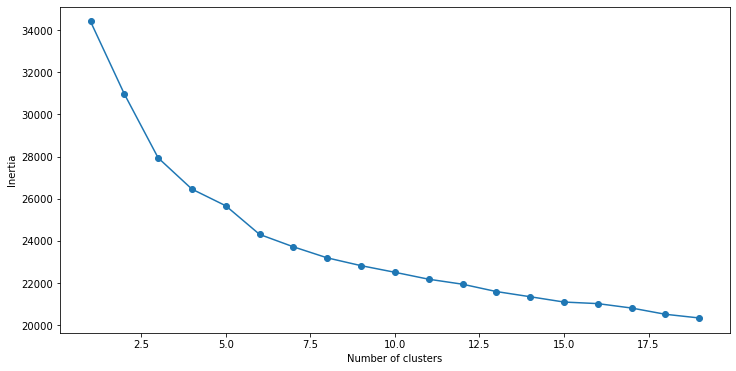

In [22]:
#pipe_scaled = scaler.fit_transform(pipequal)
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(pipequal)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame2 = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame2['Cluster'], frame2['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [23]:
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
kmeans.fit(pipequal)
pred = kmeans.predict(pipequal)
frame2 = pd.DataFrame(pipequal, columns= pipequal.columns)
frame2['cluster2'] = pred
frame2['cluster2'].value_counts()

0    1021
1     933
4     740
2     147
3      78
Name: cluster2, dtype: int64

Merging the two dataframes back together then splitting them back into the training and testing dataframes.

In [24]:
pipe = pd.concat([frame1, frame2], axis=1)

trainsc = pipe.truncate(before=0, after=1459)
testsc = pipe.truncate(before=1460, after=2918)

Implementing random forest to look at feature importance before implementing gradient boosted regression

In [25]:
labels = trainsc
x_train, x_test, y_train, y_test = train_test_split(trainsc, labels, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(trainsc, labels, test_size=0.2)

C:\Users\Isaac Hulsey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


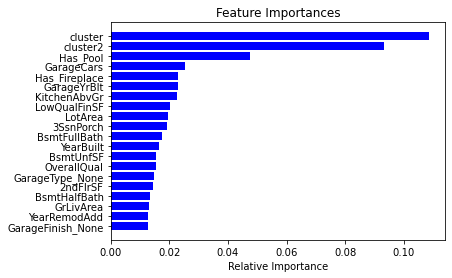

In [26]:
erf = ExtraTreesRegressor(random_state = 1)
erf.fit(x_train,y_train)
y_pred = erf.predict(x_test)
features = x_train.columns
importances = erf.feature_importances_
indices = np.argsort(importances)[-20:] #This will give the top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Reloading the train and testing data because they got messed up.

In [27]:
test = pd.read_csv('test.csv')
train= pd.read_csv('train.csv')

Loading Gradient Boosting Regressor

In [28]:
GBR=GradientBoostingRegressor()

Defining parameters and running random search for hyper parameterization

In [29]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(500)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2,10,50,100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#step size shrinkage
learning_rate = [.01, .10, .20, .05]
#percentage of samples used per tree
subsample = [.25, .5,.75,1]
#Max features used per tree
max_features = [100,150,200]

In [30]:
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
GBR_random = RandomizedSearchCV(estimator = GBR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [33]:
GBR_random.fit(trainsc,train.SalePrice)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [34]:
GBR_random.best_params_

{'subsample': 0.5,
 'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 150,
 'max_depth': 5,
 'learning_rate': 0.01}

Defining the selected hyper parameters and fitting the model on training data and running predictions on the testing data.

In [35]:
regr_1 = GradientBoostingRegressor(subsample=.5,n_estimators=600,min_samples_split=2,min_samples_leaf=1,max_features=150,max_depth=5,learning_rate=.01)
regr_1.fit(trainsc,train.SalePrice)
y_1 = regr_1.predict(testsc)

Submitting predictions

In [36]:
hp = []
for i in y_1:
    hp.append(i)
test['SalePrice'] = hp
test[['Id', 'SalePrice']].to_csv('FirstGuess', index=False)

# Result:

 I achieved .12709 RMLSE which can be seen [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard).

# Conclusion:

I challenged myself to use techniques that I had learned from my master's program over various projects and to attempt to achieve the best prediction results in the course of one afternoon. If I were to improve my work, I would consider using outlier analysis to remove any outliers that hurt the generalization of the model, I would do more feature engineering and consider dropping collinear features, and I would look into more ensemble methods that may perform better than Gradient Boosted Decision Trees. I think achieving a .12709 RMLSE in one afternoon with a forced 50-50 split in training and testing data is fairly impressive, and I hope to explore more methods of ensemble in the future and maybe revisit this project in the future to gauge how much I've learned.